In this notebook, I used clean_text_final data and runing a model with different parameters on both clean data and balanced data as well. Used 3 different methods for balancing data for comparison including "SMOTE", "ADASYN" and "Random OverSampling" methods.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import nltk
import re
from nltk.corpus import stopwords#, PlainTextCorpusReader
from nltk import word_tokenize, ngrams
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import seaborn as sns
from datetime import datetime, date, timedelta
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, balanced_accuracy_score, f1_score
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

from keras.preprocessing import sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, BatchNormalization

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from collections import Counter
import json

nltk.download('punkt')
nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mehdi.sadeghi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mehdi.sadeghi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import os
os.getcwd()

'C:\\Users\\mehdi.sadeghi\\OneDrive - Georgia Institute of Technology\\Gatech\\ISYE 6740\\Project\\archive'

In [3]:
new_directory = 'C:\\Users\\mehdi.sadeghi\\OneDrive - Georgia Institute of Technology\\Gatech\\ISYE 6740\\Project\\Emotions-main\\Emotions-main\\02_Model'

# Change the current working directory
os.chdir(new_directory)

# Verify the current working directory
current_directory = os.getcwd()
print("Current Working Directory:", current_directory)

Current Working Directory: C:\Users\mehdi.sadeghi\OneDrive - Georgia Institute of Technology\Gatech\ISYE 6740\Project\Emotions-main\Emotions-main\02_Model


# Keras tokenizer and Tensorflow model

In [5]:
def result_plot(results, name): # name is a string of 'accuracy' or 'loss'
    best_epoch = results.history['val_accuracy'].index(max(results.history['val_accuracy'])) + 1
    plt.figure(figsize=(10, 6))

    # Plot training and validation accuracy/loss
    epochs = range(1, len(results.history[name]) + 1)
    plt.plot(epochs, results.history[name], label='Training '+name, color='blue')
    plt.plot(epochs, results.history['val_'+name], label='Validation '+name, color='red')
    plt.scatter(best_epoch, results.history['val_'+name][best_epoch - 1], color='green', label=f'Best Epoch: {best_epoch}')

    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel(name.capitalize(), fontsize=14)
    plt.title('Training and Validation '+name.capitalize(), fontsize=16)
    plt.legend(fontsize=12)
    plt.xticks(epochs, fontsize=14)  # Increase font size for x-ticks
    plt.yticks(fontsize=14)

    plt.tight_layout()
    plt.show()

In [45]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score
def evaluate_model(model, X_test_pd):
    predictions =model.predict(X_test_pd)
    predicted_classes = np.argmax(predictions, axis=1)
    test_accuracy = accuracy_score(y_test, predicted_classes)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    f1 = f1_score(y_test, predicted_classes, average='weighted')
    print(f"F1-Score: {f1:.4f}")
    
    conf_matrix = confusion_matrix(y_test, predicted_classes)
    print("Confusion Matrix:")
    print(conf_matrix)
    
    recall = recall_score(y_test, predicted_classes, average=None)
    print("Recall for Each Class:")
    for i, rec in enumerate(recall):
        print(f"Class {i}: {rec:.4f}")
    
    num_classes = len(np.unique(y_test))

    accuracy_per_class = []
    for class_label in range(num_classes):
        indices = np.where(y_test == class_label)[0]
    # Extract predictions and true labels for the current class
        class_y_test = y_test[indices]
        class_y_pred = predicted_classes[indices]
    # Calculate accuracy for the current class
        accuracy = accuracy_score(class_y_test, class_y_pred)
        print(f"Accuracy for class label ",class_label, ' is: ', accuracy)

In [7]:
# Re-run codes with clean_data_final.csv
path = "../00_Data/"
filename = 'clean_text_final.csv'
clean_data= pd.read_csv(path+filename)
clean_data.tail()

,Unnamed: 0.1,Unnamed: 0,text,label,clean_text
416788,416804,416804,i feel like telling these horny devils to find...,2,feel like tell horny devil find site suit sort...
416789,416805,416805,i began to realize that when i was feeling agi...,3,begin realize feel agitate restless think go dish
416790,416806,416806,i feel very curious be why previous early dawn...,5,feel curious previous early dawn time seek tro...
416791,416807,416807,i feel that becuase of the tyranical nature of...,3,feel because tyrannical nature government el s...
416792,416808,416808,i think that after i had spent some time inves...,5,think spend time investigate surround things s...


In [8]:
clean_data.dtypes

Unnamed: 0.1     int64
Unnamed: 0       int64
text            object
label            int64
clean_text      object
dtype: object

In [9]:
#clean_data=pd.read_csv('./clean_text.csv')
X = clean_data['clean_text'] #clean_data.drop('label', , axis=1)
y = clean_data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [10]:
train = train.fillna('')
test = test.fillna('')
train = train.reset_index(drop=True)
test= test.reset_index(drop=True)

In [11]:
train

,clean_text,label
0,feel keen edge begin bite,1
1,watch birth video feel sentimental right,0
2,come stock cars feel excite hear cars roar mig...,1
3,get bad people especially top god must feel bl...,3
4,feel thrill regretful alarm change even firefl...,1
...,...,...
312589,tell really feel fake disgrace,0
312590,feel unsure body time feel like point prep,4
312591,refuse feel pressure see someone exclusively t...,4
312592,go downstairs polish pop tart two minutes run ...,0


In [12]:
clean_data['label'] = clean_data['label'].astype('category')

In [13]:
X_train= train['clean_text']
y_train= train['label']

X_test= test['clean_text']
y_test= test['label']

In [14]:
train[train['clean_text'].isnull()]

,clean_text,label


this comments is for first cleaning try that caused some texts be null: Looks like there are some rows in our dataset which are null after cleaning data, therefore we need to replace those rows with  '' before tokenizing it.

# Unbalanced Data Modeling

The Tokenizer class in TensorFlow's Keras API is used for converting text documents into tokenized sequences, which can then be used for training machine learning models, particularly neural networks. 

In [15]:
tkn = Tokenizer(num_words=80000)
tkn.fit_on_texts(X_train)
tkn.fit_on_texts(X_test)
sq_X_train = tkn.texts_to_sequences(X_train)
sq_X_test = tkn.texts_to_sequences(X_test)

size = max(len(tokens) for tokens in sq_X_train)
X_train_pd = pad_sequences(sq_X_train, padding='post', maxlen=size)
X_test_pd = pad_sequences(sq_X_test, padding='post', maxlen=size)

print("Train Sequence Length is: ", size)

Train Sequence Length is:  50


In [16]:
X_train_pd.shape

(312594, 50)

In [17]:
y_train.shape

(312594,)

In [63]:
# Create a new Sequential model
model = Sequential()

# Define parameters
vocab_size = 100000
embedding_dim = 64 #368
lstm_units = 128
dense_units = 64
num_classes = 6
dropout_rate = 0.5
#max_sequence_length = size  # Set your desired maximum sequence length

# Add layers to the model
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_shape=(size,))) #input_length=max_sequence_length))
model.add(Bidirectional(LSTM(units=lstm_units)))
model.add(BatchNormalization())
model.add(Dropout(rate=dropout_rate))
model.add(Dense(dense_units, activation='relu'))
model.add(Dropout(rate=dropout_rate))
model.add(Dense(num_classes, activation='sigmoid')) #'softmax'

# Compile the model
model.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])
model.summary()


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ (None, 50, 64)         │     6,400,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 256)            │       197,632 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,615,494 (25.24 MB)

 Trainable params: 6,614,982 (25.23 MB)

 Non-trainable params: 512 (2.00 KB)

In [44]:
# model results with embedding size of 368:
model_training_history= model.fit(X_train_pd, y_train, epochs=10, batch_size=64, validation_data=(X_test_pd, y_test),callbacks=[EarlyStopping(patience=5)])

Epoch 1/10
4885/4885 ━━━━━━━━━━━━━━━━━━━━ 2364s 483ms/step - accuracy: 0.8274 - loss: 0.4594 - val_accuracy: 0.9298 - val_loss: 0.1275
Epoch 2/10
4885/4885 ━━━━━━━━━━━━━━━━━━━━ 2380s 487ms/step - accuracy: 0.9290 - loss: 0.1400 - val_accuracy: 0.9195 - val_loss: 0.3262
Epoch 3/10
4885/4885 ━━━━━━━━━━━━━━━━━━━━ 2394s 490ms/step - accuracy: 0.9329 - loss: 0.1224 - val_accuracy: 0.9314 - val_loss: 0.1206
Epoch 4/10
4885/4885 ━━━━━━━━━━━━━━━━━━━━ 2409s 493ms/step - accuracy: 0.9354 - loss: 0.1143 - val_accuracy: 0.9321 - val_loss: 0.1258
Epoch 5/10
4885/4885 ━━━━━━━━━━━━━━━━━━━━ 2398s 491ms/step - accuracy: 0.9361 - loss: 0.1098 - val_accuracy: 0.9316 - val_loss: 0.1350
Epoch 6/10
4885/4885 ━━━━━━━━━━━━━━━━━━━━ 2391s 489ms/step - accuracy: 0.9387 - loss: 0.1057 - val_accuracy: 0.9319 - val_loss: 0.1310
Epoch 7/10
4885/4885 ━━━━━━━━━━━━━━━━━━━━ 2397s 491ms/step - accuracy: 0.9399 - loss: 0.0996 - val_accuracy: 0.9315 - val_loss: 0.1396
Epoch 8/10
4885/4885 ━━━━━━━━━━━━━━━━━━━━ 2402s 492ms/s

In [51]:
# Saving results
history_file_path = 'final_model_history_368.json'

# Save the model history to a JSON file
with open(history_file_path, 'w') as file:
    json.dump(model_training_history.history, file)

print(f"Model history saved to {history_file_path}")

Model history saved to final_model_history_368.json


In [52]:
with open(history_file_path, 'r') as file:
    history = json.load(file)

In [53]:
history

{'accuracy': [0.8934944272041321,
  0.9298322796821594,
  0.9323979616165161,
  0.9346628785133362,
  0.9363519549369812,
  0.9381369948387146,
  0.938220202922821,
  0.93956059217453],
 'loss': [0.26188215613365173,
  0.13734106719493866,
  0.12405193597078323,
  0.11597540229558945,
  0.10998599231243134,
  0.10615130513906479,
  0.10238184034824371,
  0.09969142824411392],
 'val_accuracy': [0.9298457503318787,
  0.9195193648338318,
  0.9314100742340088,
  0.9321202635765076,
  0.931573212146759,
  0.9318707585334778,
  0.9315060377120972,
  0.9315060377120972],
 'val_loss': [0.12754543125629425,
  0.3261687457561493,
  0.12057223170995712,
  0.12584586441516876,
  0.13502009212970734,
  0.13104481995105743,
  0.13959121704101562,
  0.14869552850723267]}

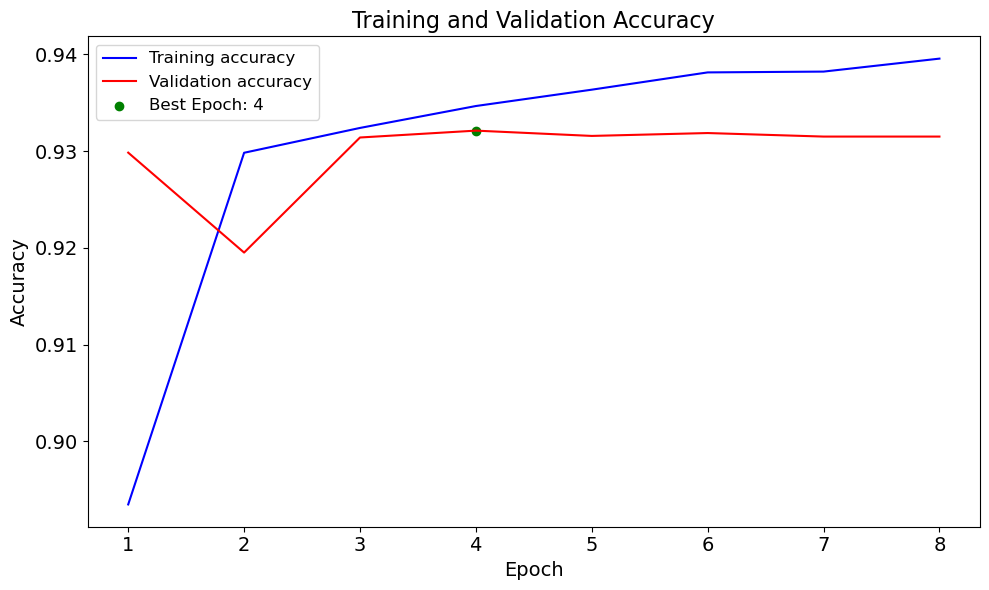

In [59]:
result_plot(model_training_history, 'accuracy')

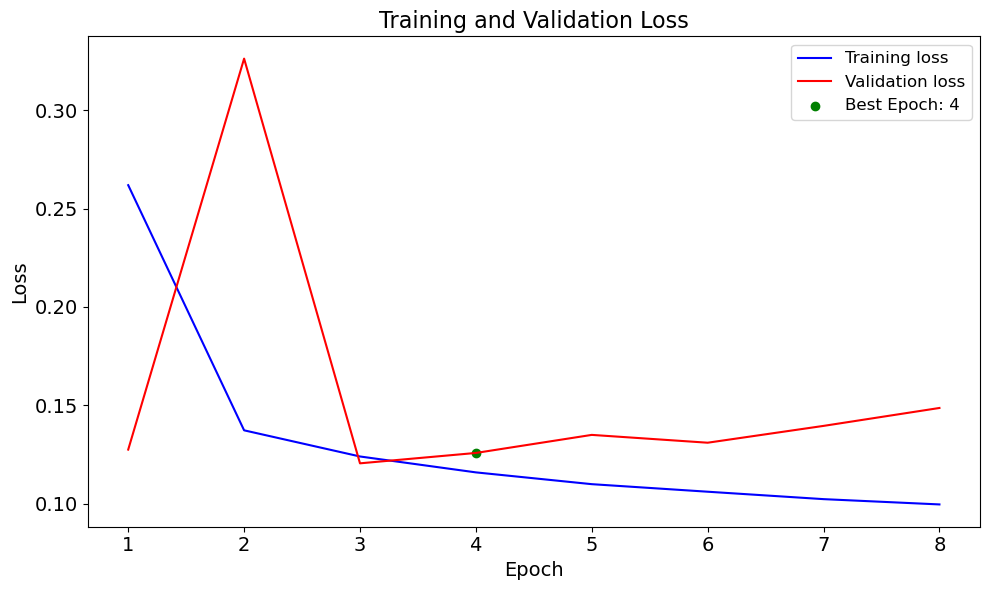

In [60]:
result_plot(model_training_history, 'loss')

From model with 368 embedding size, we get epoch 4 as the best one. Therefore we retrain the model with epoch=4 and analyze the prediction results

In [20]:
# From model with 368 embedding size, we get epoch 4 as the best one. Therefore we retrain the model with epoch=4
model.fit(X_train_pd, y_train, epochs=4, batch_size=64, validation_data=(X_test_pd, y_test),callbacks=[EarlyStopping(patience=5)])

Epoch 1/4
4885/4885 ━━━━━━━━━━━━━━━━━━━━ 2427s 496ms/step - accuracy: 0.8261 - loss: 0.4693 - val_accuracy: 0.9295 - val_loss: 0.1273
Epoch 2/4
4885/4885 ━━━━━━━━━━━━━━━━━━━━ 2420s 495ms/step - accuracy: 0.9292 - loss: 0.1393 - val_accuracy: 0.9313 - val_loss: 0.1247
Epoch 3/4
4885/4885 ━━━━━━━━━━━━━━━━━━━━ 2446s 501ms/step - accuracy: 0.9333 - loss: 0.1224 - val_accuracy: 0.9318 - val_loss: 0.1204
Epoch 4/4
4885/4885 ━━━━━━━━━━━━━━━━━━━━ 2475s 507ms/step - accuracy: 0.9351 - loss: 0.1159 - val_accuracy: 0.9295 - val_loss: 0.1257


In [25]:
evaluate_model(model, X_test_pd)

3257/3257 ━━━━━━━━━━━━━━━━━━━━ 74s 23ms/step
Test Accuracy: 0.9295
F1-Score: 0.9303
Confusion Matrix:
[[29051    41    86   867   241    10]
 [  186 31916  2627   144    67   326]
 [   40   235  8289    41    28     6]
 [   75    34    15 14135    64     5]
 [  418    25     7   679 10785    13]
 [   33    11     1     3  1023  2672]]
Recall for Each Class:
Class 0: 0.9589
Class 1: 0.9050
Class 2: 0.9595
Class 3: 0.9865
Class 4: 0.9043
Class 5: 0.7139


In [ ]:
#saving the model
model.save('unbalanced_model_epoch4_368.keras')

In [61]:
#This is how we can load the saved .keras model
# first building original model architecture and then add weights of teh saved model to that.

import tensorflow as tf
from tensorflow.keras.models import load_model

model2 = Sequential()
vocab_size = 100000
embedding_dim = 368
lstm_units = 128
dense_units = 64
num_classes = 6
dropout_rate = 0.5
#max_sequence_length = size  # Set your desired maximum sequence length

# Add layers to the model
model2.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_shape=(size,))) #input_length=max_sequence_length))
model2.add(Bidirectional(LSTM(units=lstm_units)))
model2.add(BatchNormalization())
model2.add(Dropout(rate=dropout_rate))
model2.add(Dense(dense_units, activation='relu'))
model2.add(Dropout(rate=dropout_rate))
model2.add(Dense(num_classes, activation='sigmoid')) #'softmax'

model2.load_weights('unbalanced_model_epoch4_368.keras')

#loaded_model = tf.keras.models.load_model('unbalanced_model_epoch4_368.keras')

In [48]:
evaluate_model(model2, X_test_pd)

3257/3257 ━━━━━━━━━━━━━━━━━━━━ 70s 21ms/step
Test Accuracy: 0.9295
F1-Score: 0.9303
Confusion Matrix:
[[29051    41    86   867   241    10]
 [  186 31916  2627   144    67   326]
 [   40   235  8289    41    28     6]
 [   75    34    15 14135    64     5]
 [  418    25     7   679 10785    13]
 [   33    11     1     3  1023  2672]]
Recall for Each Class:
Class 0: 0.9589
Class 1: 0.9050
Class 2: 0.9595
Class 3: 0.9865
Class 4: 0.9043
Class 5: 0.7139
Accuracy for class label  0  is:  0.9589054660681278
Accuracy for class label  1  is:  0.9050076560993592
Accuracy for class label  2  is:  0.9594860516263456
Accuracy for class label  3  is:  0.9865298715801228
Accuracy for class label  4  is:  0.9042508593946508
Accuracy for class label  5  is:  0.7138658829815656



Accuracy for class #5 has lowest value: sadness (0), joy (1), love (2), anger (3), fear (4), surprise (5)
The issue can be explained by the insufficient data available for class 5 in our training set. Due to this lack of data, the model has not had enough opportunities to learn and improve its ability to make accurate predictions for class 5

In [ ]:
# repeating the same process for smaller models, changing the embedding size from 368 to 64:

In [55]:
# model results with embedding size of 64:
model_training_history_64= model.fit(X_train_pd, y_train, epochs=10, batch_size=64, validation_data=(X_test_pd, y_test),callbacks=[EarlyStopping(patience=5)])

Epoch 1/10
4885/4885 ━━━━━━━━━━━━━━━━━━━━ 644s 131ms/step - accuracy: 0.8083 - loss: 0.5230 - val_accuracy: 0.8302 - val_loss: 0.6678
Epoch 2/10
4885/4885 ━━━━━━━━━━━━━━━━━━━━ 639s 131ms/step - accuracy: 0.9246 - loss: 0.1569 - val_accuracy: 0.9302 - val_loss: 0.1229
Epoch 3/10
4885/4885 ━━━━━━━━━━━━━━━━━━━━ 647s 132ms/step - accuracy: 0.9310 - loss: 0.1293 - val_accuracy: 0.9312 - val_loss: 0.1220
Epoch 4/10
4885/4885 ━━━━━━━━━━━━━━━━━━━━ 652s 134ms/step - accuracy: 0.9331 - loss: 0.1187 - val_accuracy: 0.9319 - val_loss: 0.1203
Epoch 5/10
4885/4885 ━━━━━━━━━━━━━━━━━━━━ 648s 133ms/step - accuracy: 0.9352 - loss: 0.1130 - val_accuracy: 0.9312 - val_loss: 0.1275
Epoch 6/10
4885/4885 ━━━━━━━━━━━━━━━━━━━━ 652s 134ms/step - accuracy: 0.9378 - loss: 0.1063 - val_accuracy: 0.9314 - val_loss: 0.1255
Epoch 7/10
4885/4885 ━━━━━━━━━━━━━━━━━━━━ 656s 134ms/step - accuracy: 0.9381 - loss: 0.1027 - val_accuracy: 0.9317 - val_loss: 0.1281
Epoch 8/10
4885/4885 ━━━━━━━━━━━━━━━━━━━━ 660s 135ms/step - ac

In [62]:
#saving output:
history_file_path = 'final_model_history_64.json'

# Save the model history to a JSON file
with open(history_file_path, 'w') as file:
    json.dump(model_training_history.history, file)

print(f"Model history saved to {history_file_path}")

Model history saved to final_model_history_64.json


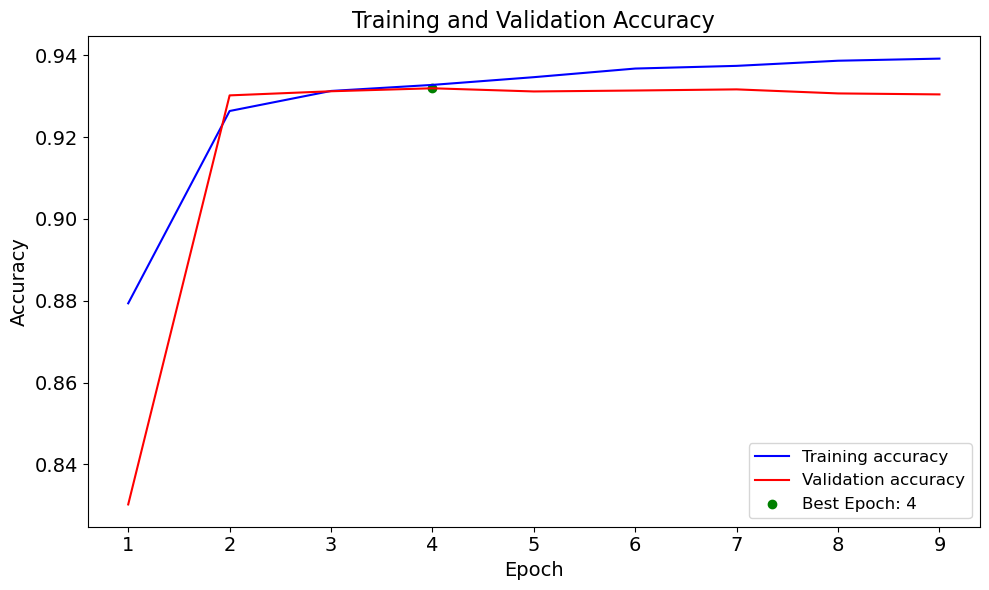

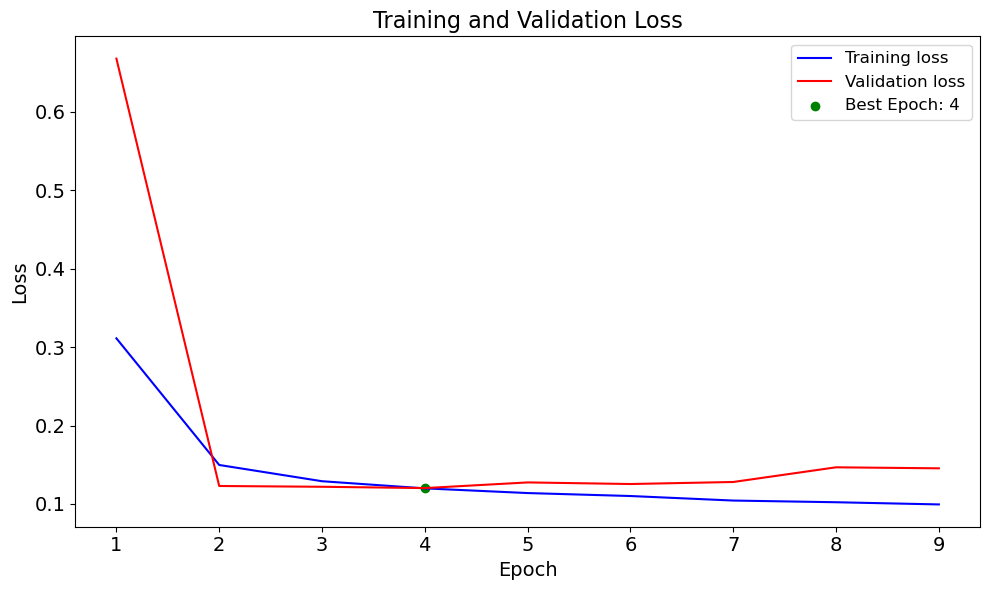

In [61]:
result_plot(model_training_history_64, 'accuracy')
result_plot(model_training_history_64, 'loss')

In [64]:
model.fit(X_train_pd, y_train, epochs=4, batch_size=64, validation_data=(X_test_pd, y_test),callbacks=[EarlyStopping(patience=5)])

Epoch 1/4
4885/4885 ━━━━━━━━━━━━━━━━━━━━ 618s 126ms/step - accuracy: 0.8051 - loss: 0.5321 - val_accuracy: 0.9253 - val_loss: 0.1580
Epoch 2/4
4885/4885 ━━━━━━━━━━━━━━━━━━━━ 620s 127ms/step - accuracy: 0.9253 - loss: 0.1527 - val_accuracy: 0.9291 - val_loss: 0.1259
Epoch 3/4
4885/4885 ━━━━━━━━━━━━━━━━━━━━ 620s 127ms/step - accuracy: 0.9312 - loss: 0.1277 - val_accuracy: 0.9209 - val_loss: 0.2842
Epoch 4/4
4885/4885 ━━━━━━━━━━━━━━━━━━━━ 622s 127ms/step - accuracy: 0.9341 - loss: 0.1189 - val_accuracy: 0.9312 - val_loss: 0.1214


In [65]:
model.save('unbalanced_model_epoch4_64.keras')

In [66]:
evaluate_model(model, X_test_pd)

3257/3257 ━━━━━━━━━━━━━━━━━━━━ 48s 15ms/step
Test Accuracy: 0.9312
F1-Score: 0.9301
Confusion Matrix:
[[28680    82    55   843   602    34]
 [  119 34595    36   116    63   337]
 [   59  2710  5789    39    23    19]
 [   89    50     8 13545   611    25]
 [   38    36     5    86 10723  1039]
 [   21     8     0     1    14  3699]]
Recall for Each Class:
Class 0: 0.9467
Class 1: 0.9810
Class 2: 0.6701
Class 3: 0.9454
Class 4: 0.8991
Class 5: 0.9882
Accuracy for class label  0  is:  0.9466596250330077
Accuracy for class label  1  is:  0.9809731752963194
Accuracy for class label  2  is:  0.6701007061002431
Accuracy for class label  3  is:  0.9453517587939698
Accuracy for class label  4  is:  0.8990525697996143
Accuracy for class label  5  is:  0.9882447234838365


# with balanced data

In [49]:
model = Sequential()

# Define parameters
vocab_size = 100000
embedding_dim = 64
lstm_units = 128
dense_units = 64
num_classes = 6
dropout_rate = 0.5
#max_sequence_length = size  # Set your desired maximum sequence length

# Add layers to the model
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_shape=(size,))) #input_length=max_sequence_length))
model.add(Bidirectional(LSTM(units=lstm_units)))
model.add(BatchNormalization())
model.add(Dropout(rate=dropout_rate))
model.add(Dense(dense_units, activation='relu'))
model.add(Dropout(rate=dropout_rate))
model.add(Dense(num_classes, activation='sigmoid')) #'softmax'

# Compile the model
model.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])
model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 50, 64)         │     6,400,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 256)            │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,615,494 (25.24 MB)

 Trainable params: 6,614,982 (25.23 MB)

 Non-trainable params: 512 (2.00 KB)

In [32]:
class_counts = train['label'].value_counts()
# Sort the counts from smallest to largest
class_counts_sorted = class_counts.sort_values()
class_counts_sorted

5     11229
2     25915
4     35782
3     42983
0     90887
1    105798
Name: label, dtype: int64

In [33]:
train.columns

Index(['clean_text', 'label'], dtype='object')

In [50]:
X_train= train['clean_text']
y_train= train['label']

X_test= test['clean_text']
y_test= test['label']

In [51]:
tkn = Tokenizer(num_words=80000)
tkn.fit_on_texts(X_train)
tkn.fit_on_texts(X_test)

# Convert text to sequences
sq_X_train = tkn.texts_to_sequences(X_train)
sq_X_test = tkn.texts_to_sequences(X_test)
balanced_size = max(len(tokens) for tokens in sq_X_train)
X_train_pd = pad_sequences(sq_X_train, padding='post', maxlen=balanced_size)
X_test_pd = pad_sequences(sq_X_test, padding='post', maxlen=balanced_size)

In [52]:
# Initialize SMOTE for oversampling
sm = SMOTE(random_state=25, n_jobs=-1, k_neighbors=5)

#reshape X_train_pd and y_train for SMOTE
X_train_pd_reshaped = X_train_pd.reshape(X_train_pd.shape[0], -1)
X_train_balanced, y_train_balanced = sm.fit_resample(X_train_pd_reshaped, y_train)

# Reshape X_train_balanced back to 3D shape for model input
X_train_balanced = X_train_balanced.reshape(X_train_balanced.shape[0], balanced_size)
y_train_balanced = np.array(y_train_balanced)

In [53]:
len(X_train_balanced)

634788

In [ ]:
#Outputs cleared
model_training_history_64= model.fit(X_train_balanced, y_train_balanced, epochs=10, batch_size=64, validation_data=(X_test_pd, y_test),callbacks=[EarlyStopping(patience=5)])

In [54]:
model.fit(X_train_balanced, y_train_balanced, epochs=3, batch_size=64, validation_data=(X_test_pd, y_test),callbacks=[EarlyStopping(patience=5)])

Epoch 1/3
9919/9919 ━━━━━━━━━━━━━━━━━━━━ 1245s 125ms/step - accuracy: 0.5358 - loss: 1.2209 - val_accuracy: 0.9160 - val_loss: 0.2880
Epoch 2/3
9919/9919 ━━━━━━━━━━━━━━━━━━━━ 1237s 125ms/step - accuracy: 0.6302 - loss: 0.9334 - val_accuracy: 0.9148 - val_loss: 0.2524
Epoch 3/3
9919/9919 ━━━━━━━━━━━━━━━━━━━━ 1245s 125ms/step - accuracy: 0.6415 - loss: 0.8862 - val_accuracy: 0.9136 - val_loss: 0.2427


In [55]:
model.save('SMOTEbalanced_model_epoch3_64.keras')

In [56]:
evaluate_model(model, X_test_pd)

3257/3257 ━━━━━━━━━━━━━━━━━━━━ 54s 17ms/step
Test Accuracy: 0.9136
F1-Score: 0.9150
Confusion Matrix:
[[28513    84   159   434   610   496]
 [   65 33765   372    95    79   890]
 [   72  2415  5925    36    26   165]
 [  464    66    48 13174   331   245]
 [   78    59    27   421 10291  1051]
 [   13    32     0     1   166  3531]]
Recall for Each Class:
Class 0: 0.9411
Class 1: 0.9574
Class 2: 0.6858
Class 3: 0.9195
Class 4: 0.8628
Class 5: 0.9434
Accuracy for class label  0  is:  0.9411473461843147
Accuracy for class label  1  is:  0.9574377587478025
Accuracy for class label  2  is:  0.6858432688968631
Accuracy for class label  3  is:  0.9194584031267449
Accuracy for class label  4  is:  0.8628322293954892
Accuracy for class label  5  is:  0.9433609404221213


### Not seen improvement when using SMOTE over sampling, therefore doing ADASYN instead

## ADASYN Oversampling

In [57]:
# ADASYN oversampling
adasyn = ADASYN(random_state=25, n_neighbors=5, sampling_strategy='minority')

X_train_pd_reshaped = X_train_pd.reshape(X_train_pd.shape[0], -1)
X_train_balanced, y_train_balanced = adasyn.fit_resample(X_train_pd_reshaped, y_train)

balanced_size = X_train_pd.shape[1]
X_train_balanced = X_train_balanced.reshape(X_train_balanced.shape[0], balanced_size)
y_train_balanced = np.array(y_train_balanced)

In [74]:
model_training_history_64= model.fit(X_train_balanced, y_train_balanced, epochs=10, batch_size=64, validation_data=(X_test_pd, y_test),callbacks=[EarlyStopping(patience=5)])

Epoch 1/10
6304/6304 ━━━━━━━━━━━━━━━━━━━━ 842s 133ms/step - accuracy: 0.7601 - loss: 0.6755 - val_accuracy: 0.9176 - val_loss: 0.1886
Epoch 2/10
6304/6304 ━━━━━━━━━━━━━━━━━━━━ 823s 131ms/step - accuracy: 0.8956 - loss: 0.2680 - val_accuracy: 0.9227 - val_loss: 0.1651
Epoch 3/10
6304/6304 ━━━━━━━━━━━━━━━━━━━━ 815s 129ms/step - accuracy: 0.9092 - loss: 0.2236 - val_accuracy: 0.9244 - val_loss: 0.1553
Epoch 4/10
6304/6304 ━━━━━━━━━━━━━━━━━━━━ 822s 130ms/step - accuracy: 0.9165 - loss: 0.1972 - val_accuracy: 0.9112 - val_loss: 0.1922
Epoch 5/10
6304/6304 ━━━━━━━━━━━━━━━━━━━━ 831s 132ms/step - accuracy: 0.9231 - loss: 0.1770 - val_accuracy: 0.9199 - val_loss: 0.1714
Epoch 6/10
6304/6304 ━━━━━━━━━━━━━━━━━━━━ 835s 132ms/step - accuracy: 0.9275 - loss: 0.1629 - val_accuracy: 0.4654 - val_loss: 2.6479
Epoch 7/10
6304/6304 ━━━━━━━━━━━━━━━━━━━━ 837s 133ms/step - accuracy: 0.9305 - loss: 0.1524 - val_accuracy: 0.9182 - val_loss: 0.1834
Epoch 8/10
6304/6304 ━━━━━━━━━━━━━━━━━━━━ 844s 134ms/step - ac

In [ ]:
model.fit(X_train_balanced, y_train_balanced, epochs=3, batch_size=64, validation_data=(X_test_pd, y_test),callbacks=[EarlyStopping(patience=5)])

In [ ]:
model.save('ADASYNbalanced_model_epoch3_64.keras')

In [ ]:
evaluate_model(model, X_test_pd)

## Random OverSampling

In [36]:
ros = RandomOverSampler(random_state=25)

X_train_pd_reshaped = X_train_pd.reshape(X_train_pd.shape[0], -1)
X_train_balanced, y_train_balanced = ros.fit_resample(X_train_pd_reshaped, y_train)

balanced_size = X_train_pd.shape[1]
X_train_balanced = X_train_balanced.reshape(X_train_balanced.shape[0], balanced_size)
y_train_balanced = np.array(y_train_balanced)

In [37]:
len(y_train_balanced)

634788

In [38]:
unique_labels, label_counts = np.unique(y_train_balanced, return_counts=True)
for label, count in zip(unique_labels, label_counts):
    print(f"Label {label}: {count} rows")

Label 0: 105798 rows
Label 1: 105798 rows
Label 2: 105798 rows
Label 3: 105798 rows
Label 4: 105798 rows
Label 5: 105798 rows


In [85]:
model_training_history_ROS= model.fit(X_train_balanced, y_train_balanced, epochs=10, batch_size=64, validation_data=(X_test_pd, y_test),callbacks=[EarlyStopping(patience=5)])

Epoch 1/10
9919/9919 ━━━━━━━━━━━━━━━━━━━━ 1329s 134ms/step - accuracy: 0.8538 - loss: 0.4088 - val_accuracy: 0.9281 - val_loss: 0.1513
Epoch 2/10
9919/9919 ━━━━━━━━━━━━━━━━━━━━ 1433s 144ms/step - accuracy: 0.9453 - loss: 0.1378 - val_accuracy: 0.9298 - val_loss: 0.1499
Epoch 3/10
9919/9919 ━━━━━━━━━━━━━━━━━━━━ 1338s 135ms/step - accuracy: 0.9497 - loss: 0.1235 - val_accuracy: 0.9306 - val_loss: 0.1546
Epoch 4/10
9919/9919 ━━━━━━━━━━━━━━━━━━━━ 1350s 136ms/step - accuracy: 0.9522 - loss: 0.1154 - val_accuracy: 0.9300 - val_loss: 0.1668
Epoch 5/10
9919/9919 ━━━━━━━━━━━━━━━━━━━━ 1377s 139ms/step - accuracy: 0.9534 - loss: 0.1102 - val_accuracy: 0.9297 - val_loss: 0.1817
Epoch 6/10
9919/9919 ━━━━━━━━━━━━━━━━━━━━ 1393s 140ms/step - accuracy: 0.9550 - loss: 0.1073 - val_accuracy: 0.9293 - val_loss: 0.2000
Epoch 7/10
9919/9919 ━━━━━━━━━━━━━━━━━━━━ 1413s 142ms/step - accuracy: 0.9560 - loss: 0.1041 - val_accuracy: 0.9289 - val_loss: 0.2219


From above cell, epoch  3 got a better accuracy, Therefore, fitting/re-training the model with epoch3 for later predictions

In [40]:
model.fit(X_train_balanced, y_train_balanced, epochs=3, batch_size=64, validation_data=(X_test_pd, y_test),callbacks=[EarlyStopping(patience=5)])

Epoch 1/3
9919/9919 ━━━━━━━━━━━━━━━━━━━━ 1315s 132ms/step - accuracy: 0.8506 - loss: 0.4203 - val_accuracy: 0.9279 - val_loss: 0.1517
Epoch 2/3
9919/9919 ━━━━━━━━━━━━━━━━━━━━ 1252s 126ms/step - accuracy: 0.9444 - loss: 0.1400 - val_accuracy: 0.9297 - val_loss: 0.1502
Epoch 3/3
9919/9919 ━━━━━━━━━━━━━━━━━━━━ 1210s 122ms/step - accuracy: 0.9494 - loss: 0.1238 - val_accuracy: 0.9308 - val_loss: 0.1628


In [41]:
model.save('ROSbalanced_model_epoch3_64.keras')

In [46]:
evaluate_model(model, X_test_pd)

3257/3257 ━━━━━━━━━━━━━━━━━━━━ 42s 13ms/step
Test Accuracy: 0.9308
F1-Score: 0.9330
Confusion Matrix:
[[28689    56    82   828   592    49]
 [  112 31875  2694   155    73   357]
 [   54    72  8443    40    12    18]
 [   82    38    23 13743   426    16]
 [   25    28    18   263 10560  1033]
 [    2     8     2     2    46  3683]]
Recall for Each Class:
Class 0: 0.9470
Class 1: 0.9038
Class 2: 0.9773
Class 3: 0.9592
Class 4: 0.8854
Class 5: 0.9840
Accuracy for class label  0  is:  0.9469566939529971
Accuracy for class label  1  is:  0.9038450632337095
Accuracy for class label  2  is:  0.9773121889107536
Accuracy for class label  3  is:  0.9591708542713567
Accuracy for class label  4  is:  0.8853860987675023
Accuracy for class label  5  is:  0.9839700774779588


Comparing these results (model trained with balanced data) with other models results (trained with unbalanced data), indicates an improvement on model capabilities to predict all classes accurate.Balancing the dataset can lead to more stable performance across all classes, particularly for minority classes like Class 5 in this scenario. 
This results indicates the importance of dataset balance in classification tasks to avoid biases towards majority classes and achieve better overall model performance.

# These are for previous clean_data 

In [27]:
model.compile(optimizer=Adam(learning_rate=0.001), metrics=['accuracy'], loss=SparseCategoricalCrossentropy())

print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 48, 100)        │    10,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,252,358 (39.11 MB)

 Trainable params: 10,251,846 (39.11 MB)

 Non-trainable params: 512 (2.00 KB)

None


In [28]:
model_training_history= model.fit(X_train_pd, y_train, epochs=10, batch_size=64, validation_data=(X_test_pd, y_test),callbacks=[EarlyStopping(patience=5)])

Epoch 1/10
4885/4885 ━━━━━━━━━━━━━━━━━━━━ 868s 177ms/step - accuracy: 0.8113 - loss: 0.5105 - val_accuracy: 0.9237 - val_loss: 0.1488
Epoch 2/10
4885/4885 ━━━━━━━━━━━━━━━━━━━━ 843s 173ms/step - accuracy: 0.9276 - loss: 0.1435 - val_accuracy: 0.9303 - val_loss: 0.1236
Epoch 3/10
4885/4885 ━━━━━━━━━━━━━━━━━━━━ 850s 174ms/step - accuracy: 0.9321 - loss: 0.1273 - val_accuracy: 0.9321 - val_loss: 0.1286
Epoch 4/10
4885/4885 ━━━━━━━━━━━━━━━━━━━━ 849s 174ms/step - accuracy: 0.9344 - loss: 0.1172 - val_accuracy: 0.9319 - val_loss: 0.1235
Epoch 5/10
4885/4885 ━━━━━━━━━━━━━━━━━━━━ 854s 175ms/step - accuracy: 0.9373 - loss: 0.1075 - val_accuracy: 0.9316 - val_loss: 0.1217
Epoch 6/10
4885/4885 ━━━━━━━━━━━━━━━━━━━━ 856s 175ms/step - accuracy: 0.9390 - loss: 0.1017 - val_accuracy: 0.9304 - val_loss: 0.1405
Epoch 7/10
4885/4885 ━━━━━━━━━━━━━━━━━━━━ 860s 176ms/step - accuracy: 0.9388 - loss: 0.0997 - val_accuracy: 0.9314 - val_loss: 0.1401
Epoch 8/10
4885/4885 ━━━━━━━━━━━━━━━━━━━━ 857s 175ms/step - ac

In [89]:
model1_training_history= model1.fit(X_train_pd, y_train, epochs=10, batch_size=64, validation_data=(X_test_pd, y_test),callbacks=[EarlyStopping(patience=5)])

Epoch 1/10
4885/4885 ━━━━━━━━━━━━━━━━━━━━ 866s 177ms/step - accuracy: 0.8101 - loss: 0.5114 - val_accuracy: 0.9274 - val_loss: 0.1377
Epoch 2/10
4885/4885 ━━━━━━━━━━━━━━━━━━━━ 815s 167ms/step - accuracy: 0.9281 - loss: 0.1411 - val_accuracy: 0.9306 - val_loss: 0.1198
Epoch 3/10
4885/4885 ━━━━━━━━━━━━━━━━━━━━ 820s 168ms/step - accuracy: 0.9330 - loss: 0.1216 - val_accuracy: 0.9317 - val_loss: 0.1214
Epoch 4/10
4885/4885 ━━━━━━━━━━━━━━━━━━━━ 814s 167ms/step - accuracy: 0.9353 - loss: 0.1127 - val_accuracy: 0.9323 - val_loss: 0.1201
Epoch 5/10
4885/4885 ━━━━━━━━━━━━━━━━━━━━ 822s 168ms/step - accuracy: 0.9375 - loss: 0.1056 - val_accuracy: 0.9314 - val_loss: 0.1231
Epoch 6/10
4885/4885 ━━━━━━━━━━━━━━━━━━━━ 837s 171ms/step - accuracy: 0.9387 - loss: 0.1026 - val_accuracy: 0.9312 - val_loss: 0.1388
Epoch 7/10
4885/4885 ━━━━━━━━━━━━━━━━━━━━ 828s 170ms/step - accuracy: 0.9406 - loss: 0.0976 - val_accuracy: 0.9315 - val_loss: 0.1354


In [42]:
# saving model training history: 
import json

# Define the file path to save the model history
history_file_path = 'model_history.json'

# Save the model history to a JSON file
with open(history_file_path, 'w') as file:
    json.dump(model_training_history.history, file)

print(f"Model history saved to {history_file_path}")

Model history saved to model_history.json


In [43]:
with open(history_file_path, 'r') as file:
    history = json.load(file)

In [39]:
# Extract necessary training history data
training_loss = model_training_history.history['loss']
training_accuracy = model_training_history.history['accuracy']
validation_loss = model_training_history.history['val_loss']
validation_accuracy = model_training_history.history['val_accuracy']

# Create a dictionary to store the training history data
training_history_data = {
    'loss': training_loss,
    'accuracy': training_accuracy,
    'val_loss': validation_loss,
    'val_accuracy': validation_accuracy
}

# Define the file path to save the training history
history_file_path = 'model_training_history.pkl'

# Save the training history data to a file using pickle
with open(history_file_path, 'wb') as file:
    pickle.dump(training_history_data, file)

print(f"Training history saved to {history_file_path}")

Training history saved to model_training_history.pkl


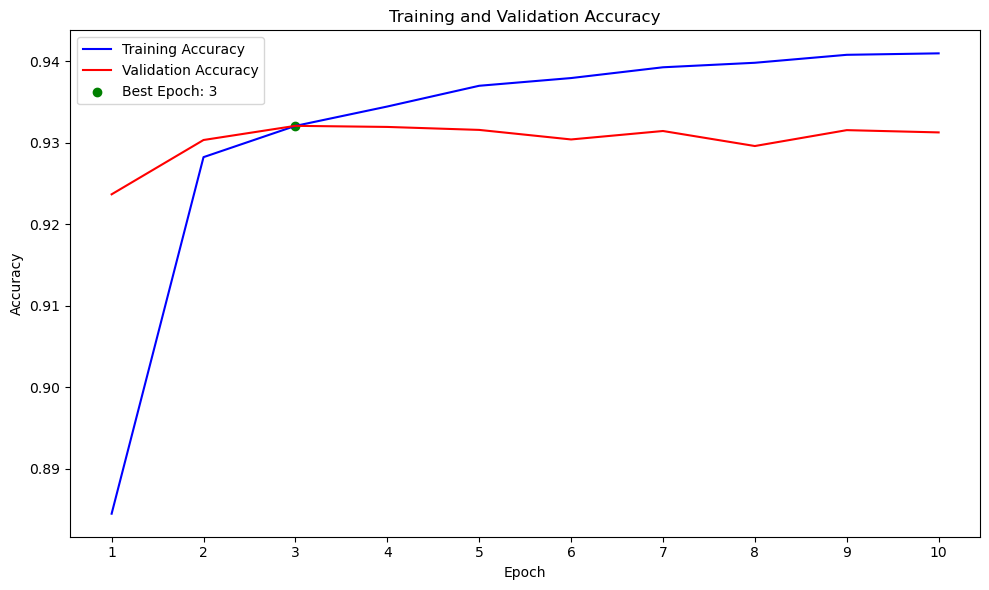

In [34]:
# Determine the best epoch (1-based index)
best_epoch = model_training_history.history['val_accuracy'].index(max(model_training_history.history['val_accuracy'])) + 1

# Create a new figure
plt.figure(figsize=(10, 6))

# Plot training and validation accuracy
epochs = range(1, len(model_training_history.history['accuracy']) + 1)  # Generate epoch numbers starting from 1
plt.plot(epochs, model_training_history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(epochs, model_training_history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.scatter(best_epoch, model_training_history.history['val_accuracy'][best_epoch - 1], color='green', label=f'Best Epoch: {best_epoch}')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.xticks(epochs)

# Show the plot
plt.tight_layout()
plt.show()


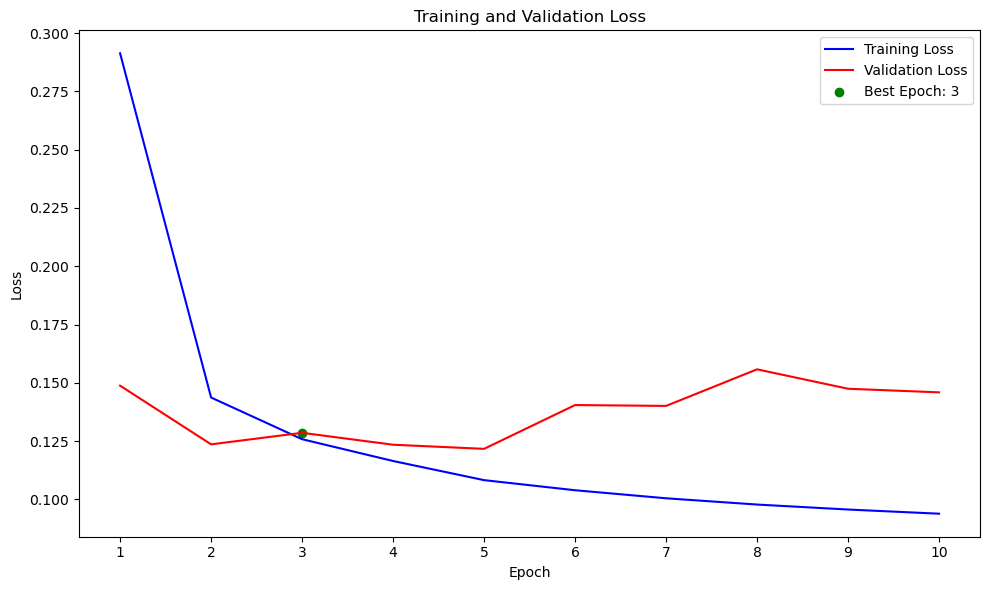

In [35]:
# Create a new figure
plt.figure(figsize=(10, 6))

# Plot training and validation loss
epochs = range(1, len(model_training_history.history['loss']) + 1)  # Generate epoch numbers starting from 1
plt.plot(epochs, model_training_history.history['loss'], label='Training Loss', color='blue')
plt.plot(epochs, model_training_history.history['val_loss'], label='Validation Loss', color='red')
plt.scatter(best_epoch, model_training_history.history['val_loss'][best_epoch - 1], color='green', label=f'Best Epoch: {best_epoch}')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Set x-axis ticks to show every epoch number
plt.xticks(epochs)

# Show the plot
plt.tight_layout()
plt.show()
